# Tutorial: HINT for approval prediction on toy model

In this tutorial, we show how to predict clinical trial approval step by step. 

Agenda:

- Part I: Import modules
- Part II: Specify task
- Part III: Pretraining 
- Part IV: Data loader
- Part V: Raw data embedding
- Part VI: Learn and inference

Let's start!

## 1. Import modules

It includes 

- Standard modules, e.g., ```PyTorch```. 
- self-defined module, e.g., ```dataloader```, ```model```. 

We also specify the device (**CPU or GPU**) using ```device = torch.device("cpu")``` or ```device = torch.device("cuda:0")```.

In [1]:
import torch, os
torch.manual_seed(0) 
import warnings;warnings.filterwarnings("ignore")
from HINT.dataloader import csv_three_feature_2_dataloader, generate_admet_dataloader_lst
from HINT.molecule_encode import MPNN, ADMET 
from HINT.icdcode_encode import GRAM, build_icdcode2ancestor_dict
from HINT.protocol_encode import Protocol_Embedding
from HINT.model import HINTModel 
device = torch.device("cpu")  ## cuda:0

## 2. Specify task
The task includes:  
- phase I prediction
- phase II prediction 
- phase III prediction
- Indication prediction


In [2]:
base_name = 'phase_I' ### 'phase_I', 'phase_II', 'phase_III', 'indication'
datafolder = "data"
train_file = os.path.join(datafolder, base_name + '_train.csv')
valid_file = os.path.join(datafolder, base_name + '_valid.csv')
test_file = os.path.join(datafolder, base_name + '_test.csv')

## 3. Pretrain

ADMET stands for 
- Absorption 
- Distribution
- Metabolism
- Excretion 
- Toxicity 

The prediction of the ADMET properties plays an important role in the drug design process because these properties account for the failure of about 60% of all drugs in the clinical phases.

In [3]:
mpnn_model = MPNN(mpnn_hidden_size = 50, mpnn_depth=3, device = device)
admet_model_path = "save_model/admet_model.ckpt"
if not os.path.exists(admet_model_path):
	admet_dataloader_lst = generate_admet_dataloader_lst(batch_size=32)
	admet_trainloader_lst = [i[0] for i in admet_dataloader_lst]
	admet_testloader_lst = [i[1] for i in admet_dataloader_lst]
	admet_model = ADMET(molecule_encoder = mpnn_model, 
						highway_num=2, 
						device = device, 
						epoch=3, 
						lr=5e-4, 
						weight_decay=0, 
						save_name = 'admet_')
	admet_model.train(admet_trainloader_lst, admet_testloader_lst)
	torch.save(admet_model, admet_model_path)
else:
	admet_model = torch.load(admet_model_path)
	admet_model = admet_model.to(device)
	admet_model.set_device(device)

## 4. Data loader

Then we define data loaders for training, validation and test data, respectively.

In [4]:
train_loader = csv_three_feature_2_dataloader(train_file, shuffle=True, batch_size=32) 
valid_loader = csv_three_feature_2_dataloader(valid_file, shuffle=False, batch_size=32) 
test_loader = csv_three_feature_2_dataloader(test_file, shuffle=False, batch_size=32) 


## 5. Raw data embedding

Then we defined data embeddor for [ICD-10 code](https://en.wikipedia.org/wiki/ICD-10) that represent hierarchy of disease code and trial protocol (eligibility criteria). 

In [5]:
icdcode2ancestor_dict = build_icdcode2ancestor_dict()
gram_model = GRAM(embedding_dim = 50, icdcode2ancestor = icdcode2ancestor_dict, device = device)
protocol_model = Protocol_Embedding(output_dim = 50, highway_num=3, device = device)


## 6. Learn and Inference

Then we describe the learning and inference process. The trained model that performs best in validation set would be saved. If there exists saved model, then we can conduct inference directly. 

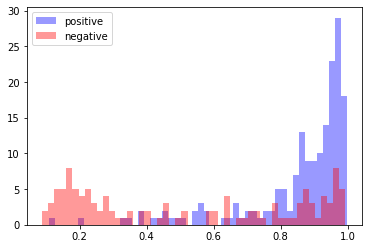

PR-AUC   mean: 0.7407 std: 0.0296
F1       mean: 0.8307 std: 0.0207
ROC-AUC  mean: 0.7962 std: 0.0307


In [6]:
hint_model_path = "save_model/" + base_name + ".ckpt"
if not os.path.exists(hint_model_path):
	model = HINTModel(molecule_encoder = mpnn_model, 
			 disease_encoder = gram_model, 
			 protocol_encoder = protocol_model,
			 device = device, 
			 global_embed_size = 50, 
			 highway_num_layer = 2,
			 prefix_name = base_name, 
			 gnn_hidden_size = 50,  
			 epoch = 5,
			 lr = 1e-3, 
			 weight_decay = 0, 
			)
	model.init_pretrain(admet_model)
	model.learn(train_loader, valid_loader, test_loader)
	model.bootstrap_test(test_loader)
	torch.save(model, hint_model_path)
else:
	model = torch.load(hint_model_path)
	model.bootstrap_test(test_loader)